In [174]:
import matplotlib.pyplot as plt
from scipy.special import factorial, factorial2
import numpy as np
import math
from decimal import Decimal, getcontext, Context
from tqdm import trange
import random

font = {
    'family' : 'serif',
    'size'   : 15,
    'weight' : 'normal'
}
colors = ['r', 'm', 'darkorange', 'gold', 'darkkhaki', 'lightskyblue']
marker_colors = ['b', 'k', 'indigo', 'maroon', 'darkgreen', 'teal']

plt.rc('font', **font)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', titlesize=22)
plt.rc('legend', fontsize=20)

## 1. Visualization of series terms, partial sums and remainders

### Rate of convergence

Let $a_n > 0$ for all $n\in\mathbb N$ and $\lim\limits_{n\to\infty} a_n = 0$. <u>There are the following types of convergence rate</u>:  
  

**Linear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = q, \quad 0<q<1.$
    
**Sublinear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = 1$.
    
**Superlinear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = 0$.
    
**Quadratic convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n^2} = \mu > 0$.

### Partial sums and remainders

<u>For any convergent series</u> $\sum\limits_{n=1}^\infty a_n = S$ with *partial sum* $S_n = \sum\limits_{k=1}^n a_k$ we have  
$$S = S_n + r_n, n\in\mathbb N, $$  
where the sequence $\{r_n\}$, $r_n = \sum\limits_{k=n+1}^\infty a_k$, is called a *tail*, or *remainder*, of the series $\sum\limits_{n=1}^\infty a_n$

Note that for a series with positive terms $S_n$ is increasing, $r_n$ is decreasing.

### Code area

**Remark 1.** The pythonic loops ($\texttt{for}$, $\texttt{while}$, $\texttt{sum}$, etc.) are much slower that $\texttt{np.sum}$ and other numpy stuff. Consider the following ways of calculating $H_n$:

In [175]:
def harmonic_slow(n):
    return sum([1. / i for i in range(1, n+1)])

def harmonic_fast(n):
    return np.sum(1. / np.arange(1, n + 1))

In [176]:
%%timeit
harmonic_slow(1000)

73.8 µs ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [177]:
%%timeit
harmonic_fast(1000)

9.47 µs ± 424 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The latter is about 6 times faster than the former. Please use numpy tools in this task whenever possible instead of plain pythonic loops.

**Remark 2.** For the sake of the computational stability sometimes it is useful to calculate terms $a_n$ involving products as $e^{\ln a_n}$. For example, 
$$
\frac 1{n!} = e^{-\sum\limits_{k=1}^n \ln k}.
$$

**(2 points) 1.1.** Complete the code for the class $\texttt{Series}$. Make sure your code produces the same pictures as listed below for the standard series.

**Caution!** Solutions using pythonic loops will receive at most **1 point**!

In [178]:
class Series:
    def __init__(self, name, term_implementation, default_sum=0, sum_estimation=None):
        '''
            name, string: labels in LaTeX
            term_implementation: a vectorized function calculating the array of terms
            default_sum, float: sum of initial terms (used if starting index is not 1)
            sum_estimation, float: approximate sum of the series (if known)
        '''
        self.name = name
        self.term_implementation = term_implementation
        self.default_sum = default_sum
        self.sum_estimation = sum_estimation
    
    def calculate_sum(self, begin, end):
        '''
            Calculate the sum a_{begin} + a_{begin + 1} + ... + a_{end - 1}
        '''
        return np.sum(self.terms(begin, end)) + self.default_sum
    
    def terms(self, n_min, n_max):
        '''
            Returns a numpy array [a_{n_min}, a_{n_min + 1}, ..., a_{n_max - 1}]
        '''
        return self.term_implementation(np.arange(n_min, n_max, dtype = np.float64))
    
    def partial_sums(self, n_min, n_max):
        '''
            Returns a numpy array [S_{n_min}, S_{n_min + 1}, ..., S_{n_max - 1}],
            where S_n is the partial sum of the series
        '''
        temp = [0]
        if n_min != 1:
            temp = self.calculate_sum(1, n_min)
        return np.cumsum(self.terms(n_min, n_max), dtype = np.float64) + self.default_sum + np.float64(temp[-1])
    
    def remainders(self, n_min, n_max):
        '''
            Returns a numpy array [r_{n_min}, r_{n_min + 1}, ..., r_{n_max - 1}],
            where r_n = S - S_n, S is an estimation of the sum of the series
        '''
        assert self.sum_estimation is not None
        return np.full(n_max - n_min, self.sum_estimation) - self.partial_sums(n_min, n_max)

    def estimate_sum(self, n_min, n_max):
        '''
            Estimate the sum of the series as a big enough partial sum:
            a_{n_min} + a_{n_min + 1} + ... + a_{n_max}
        '''
        self.sum_estimation = self.calculate_sum(n_min, n_max + 1)
        return self.sum_estimation

In [179]:
def plot(functions, n_min, n_max, title, semilogy=False, y_lims=None):
    plt.figure(figsize=(14, 7))
    
    line_colors = np.random.choice(colors, size=len(functions), replace=False)
    marker_edge_colors = np.random.choice(marker_colors, size=len(functions), replace=False)
    plot = plt.semilogy if semilogy else plt.plot
    
    for index, series in enumerate(functions):
        domain = np.arange(n_min, n_max + 1)
        if title == 'Terms':
            func = series.terms
        elif title == 'Partial sums':
            func = series.partial_sums
        elif title == 'Remainders':
            func = series.remainders
        else:
            raise ValueError('Unknown title!')
        if n_max - n_min < 50:
            plot(domain, func(domain[0], domain[-1] + 1), c=line_colors[index], lw=3,
                 markeredgecolor=marker_edge_colors[index], mew=2, marker='o', label=series.name)
        else:
            plot(domain, func(domain[0], domain[-1] + 1), c=line_colors[index], lw=3, label=series.name)
        if title == 'Partial sums':
            plot(domain, series.sum_estimation * np.ones_like(domain), '--', c=line_colors[index])

    plt.grid(ls=':')
    plt.title(title)
    plt.xlim(n_min, n_max)
    if y_lims is not None:
        if semilogy:
            plt.ylim(10 ** y_lims[0], 10 ** y_lims[1])
        else:
            plt.ylim(y_lims[0], y_lims[1])
    plt.legend();

Now let's consider the standard series from the lectures:
$$
\sum_{n=1}^{\infty} \frac 1{n(n+1)}, \quad \sum_{n=0}^{\infty} \Big(\frac 12 \Big)^n,
\quad \sum_{n=0}^{\infty} \frac 1{n!}, \quad \sum_{n=1}^{\infty} (0.99)^{2^n}:
$$

In [180]:
standard_series = [
    Series(r'$\sum{\frac{1}{n(n+1)}}$', lambda x: 1 / x / (x + 1), sum_estimation=1),
    Series(r'$\sum{\frac{1}{2^n}}$', lambda x: 0.5 ** x, default_sum=1, sum_estimation=2),
    Series(r'$\sum{\frac{1}{n!}}$', lambda x: 1 / factorial(x), default_sum=1, sum_estimation=np.e),
    Series(r'$\sum{(0.99)^{2^{n}}}$', lambda x: 0.99 ** (2 ** x))
]

Plot the first $40$ terms of these series:

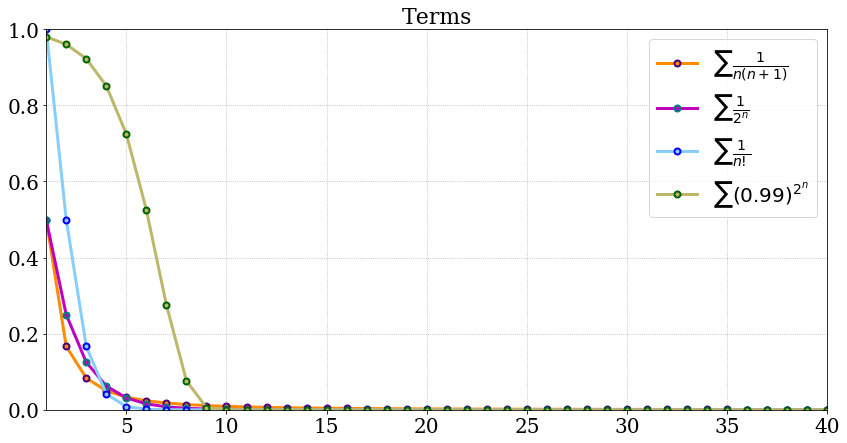

In [181]:
plot(standard_series, 1, 40, 'Terms', y_lims=(0, 1))

We can hardly see anything on this plot. That's why it is **strongly recommended** to use the logarightmic scale for the $y$-axis while dealing with infinitesimal sequences.

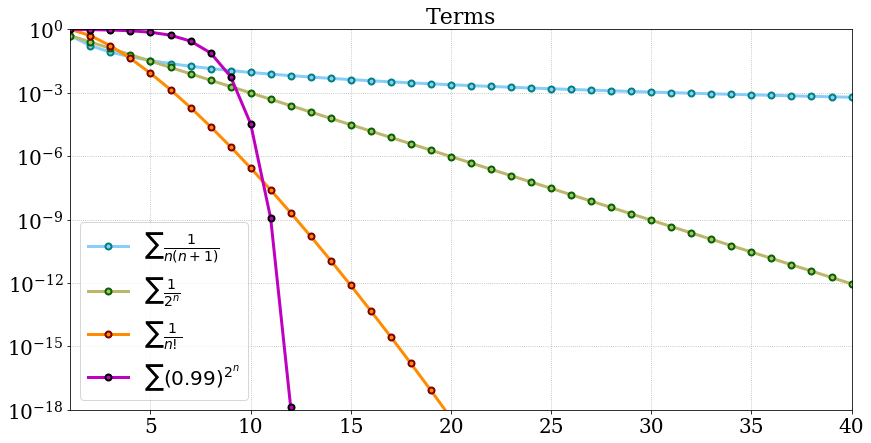

In [182]:
plot(standard_series, 1, 40, 'Terms', semilogy=True, y_lims=(-18, 0))

Here we can see all the different convergence types on this plot.

It's time to plot the partial sums along with sums of the series. The sum of the last series is calculated approximately:

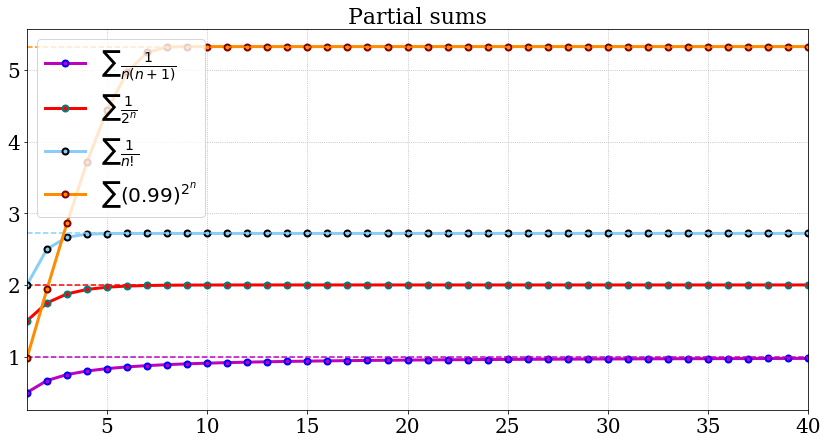

In [183]:
standard_series[-1].estimate_sum(1, 20)
plot(standard_series, 1, 40, 'Partial sums')

Now plot the remainders in semilogy mode:

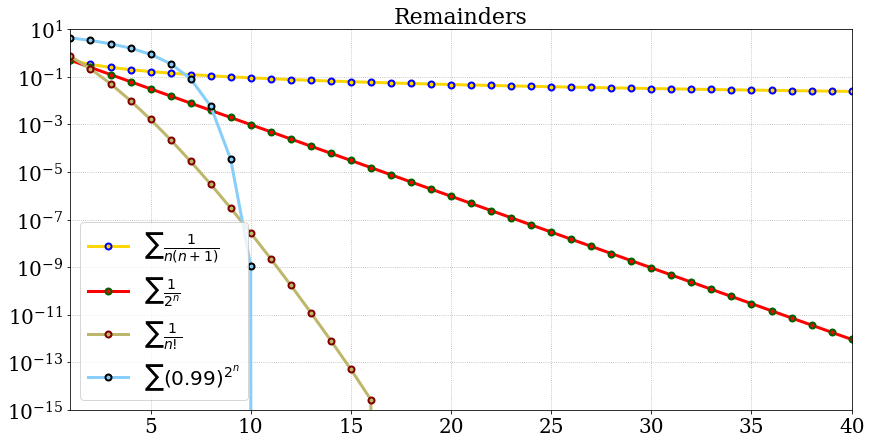

In [184]:
plot(standard_series, 1, 40, 'Remainders', semilogy=True, y_lims=(-15, 1))

Note that for each series the rate of convergence of its terms coincides with that of the remainders.

**The main task here is to do the same things with more complicated series!** Consider the series $\sum\limits_{n=1}^\infty a_n$, $\sum\limits_{n=1}^\infty b_n$, $\sum\limits_{n=1}^\infty c_n$, where

$$
a_n = \sum\limits_{n=1}^\infty \frac{(2n-1)!!}{n^n}, \quad
b_n = \sum\limits_{n=1}^\infty \frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}, \quad
c_n = \sum\limits_{n=1}^\infty \Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4.
$$

**(3 points) 1.2.** Determine the rate of convergence to $0$ of the sequences $a_n$, $b_n$, $c_n$ and establish the convergence of each series  $\sum\limits_{n=1}^\infty a_n$, $\sum\limits_{n=1}^\infty b_n$, $\sum\limits_{n=1}^\infty c_n$.

**I will use the statement from a lecture, that if the sequence $a_n$ converges linearly or superlinearly and $a_n$ -> 0 and $\sum\limits_{n=1}^\infty a_n$ terms are positive, then $\sum\limits_{n=1}^\infty a_n$ converges.**

**(a)** Let's start with the sequence $a_n$: $\lim\limits_{n\to\infty} \cfrac{(2n-1)!!}{n^n} = \lim\limits_{n\to\infty} \cfrac{(2n-1)!}{2^{n-1} \cdot (n-1)! \cdot n^n} = \lim\limits_{n\to\infty} \cfrac{(n+1)\cdot...\cdot(2n-3)\cdot(2n-1)}{2^{n-1} \cdot n^{n-1}} = 0$ because multipliers in the denominator are 2*n and product will be bigger than in the numerator.

Computing $\lim\limits_{n\to\infty} \cfrac{a_{n+1}}{a_n}$ = $\lim\limits_{n\to\infty} (\cfrac{(2n+1)!!}{(n+1)^{n+1}} \cdot \cfrac{n^n}{(2n-1)!!})$ = $\lim\limits_{n\to\infty} \cfrac{(2n+1) \cdot n^n}{(n+1)^{n+1}}$ = $\lim\limits_{n\to\infty} \cfrac{(2n+1) \cdot n^n}{(n+1)\cdot n^n \cdot (1+1/n)^{n}}$ = $\lim\limits_{n\to\infty} \cfrac{(2n+1)}{(n+1) \cdot (1+1/n)^{n}}$ = $\lim\limits_{n\to\infty} \cfrac{(2n+1)}{(n+1) \cdot e}$ = $\lim\limits_{n\to\infty} \cfrac{2\cdot (n+0,5)}{(n+1) \cdot e}$ = $\lim\limits_{n\to\infty} \cfrac{2}{e}$ = $\cfrac{2}{e} = q$ ,then $0<q<1.$ Therefore, it's a linear convergence. It means that  series  $\sum\limits_{n=1}^\infty a_n$ also converges, moreover all terms are positive and absolute value doesn't change anything, thus, it's ablosutely convergent.

**(b)**  Sequence $b_n$, $\lim\limits_{n\to\infty} \cfrac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}} = 0$ as $n^p < a^{n^2}$ for $p>0$ and $a>1$. 

Computing $\lim\limits_{n\to\infty} \cfrac{b_{n+1}}{b_n}$ = $\lim\limits_{n\to\infty} \cfrac{\sqrt{(n+1)^5+(n+1)^3+2} \cdot (1.2)^{n^2}}{(1.2)^{(n+1)^2} \cdot \sqrt{(n)^5+(n)^3+2}}$ = $\lim\limits_{n\to\infty} \cfrac{(1.2)^{n^2}}{(1.2)^{(n+1)^2}}$ = $\lim\limits_{n\to\infty} \cfrac{1}{(1.2)^{2n+1}}$ = 0, superlinear convergence, that means that $\sum\limits_{n=1}^\infty b_n$ also converges and as all terms are positive, it's a absolute convergence.

**(c)** Sequence $c_n$,   $\lim\limits_{n\to\infty} \Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4$ = $(\lim\limits_{n\to\infty} (1+\frac 1n)^{n+1} - \lim\limits_{n\to\infty} e )^4$ = $(\lim\limits_{n\to\infty} (e\cdot(1+\frac 1n)) - \lim\limits_{n\to\infty} e )^4$ = $\lim\limits_{n\to\infty} {(e - e)^4} = 0$

Computing $\lim\limits_{n\to\infty} \cfrac{c_{n+1}}{c_n}$ = $\lim\limits_{n\to\infty} \Big(\Big(1+\frac{1}{(n+1)})^{n+2} - e\Big)^4 / \Big(\Big(1+\frac{1}{n})^{n+1} - e\Big)^4$ = $\lim\limits_{n\to\infty} (\cfrac{e\cdot\frac{1}{n+1}-e}{e\cdot\frac{1}{n+1}-e})^4$ =  $\lim\limits_{n\to\infty} (\cfrac{e\cdot(1+\frac{1}{n+1}-1)}{e\cdot (1+\frac{1}{n+1}-1)})^4$ = $\lim\limits_{n\to\infty} \cfrac {n+1}{n+1} = 1$ ,thus, it's a sublinear convergence. 

Now we're going to do to do the limit comparison test for this series with $1/n^{4}$ as all terms are non-negative. Consequenly, series will converge as well.

$\lim\limits_{n\to\infty} \Big((1+\frac{1}{n})^{n+1} - e\Big)^4 / \frac{1}{n^4}$ = $\lim\limits_{n\to\infty} \Big((1+\frac{1}{n})^{n+1} - e\Big)^4 \cdot{n^4}$ = $\lim\limits_{x\to 0} \Big((1+x)^{\frac{1}{x}+1} - e\Big)^4 \cdot{\frac{1}{x^4}}$ = $\Big(\lim\limits_{x\to 0} \cfrac{(1+x)^{\frac{1}{x}+1} - e}{x}\Big)^4$, now as we get form 0/0, we are allowed to use L-Hospital rule, then $\Big(\lim\limits_{x\to 0} \cfrac{(1+x)^{\frac{1}{x}+1}\cdot(x-\log(1+x))}{x^2}\Big)^4$ = $\Big(\lim\limits_{x\to 0}(1+x)^{\frac{1}{x}+1} \cdot \lim\limits_{x\to 0}\cfrac{(x-\log(1+x))}{x^2}\Big)^4$ = $\Big(e \cdot \lim\limits_{x\to 0}\cfrac{(x-\log(1+x))}{x^2}\Big)^4$ ,here we get 0/0 again, hence we will use L-Hospital rule again: $\Big(e \cdot \lim\limits_{x\to 0}\cfrac{(x-\log(1+x))}{x^2}\Big)^4$ = $\Big(e \cdot \lim\limits_{x\to 0}\cfrac{\frac{x}{x+1}}{2x}\Big)^4$ = $\Big(e \cdot \lim\limits_{x\to 0}\cfrac{1}{2x+2}\Big)^4$ = $\Big(e \cdot \cfrac{1}{2}\Big)^4$ = $\cfrac{e^4}{16}$ ,thus we get positive number, that means that both series converge of diverge, an series 1/n^4 converges as p-series, where p=4, hence initial series converges as well.

**(3 points) 1.3.** Plot the sequences $a_n$, $b_n$, $c_n$ on the same picture in semilogy mode. Consider three cases $n_{\max} = 20, 50, 100$, setting the appropriate range for the $y$-axis

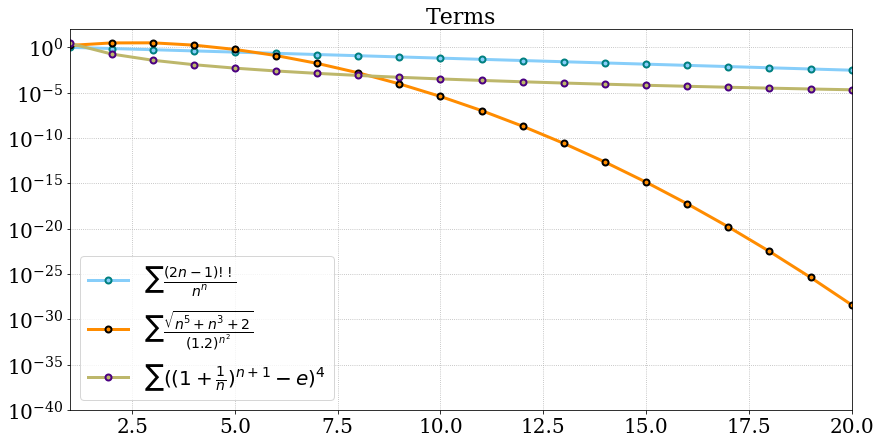

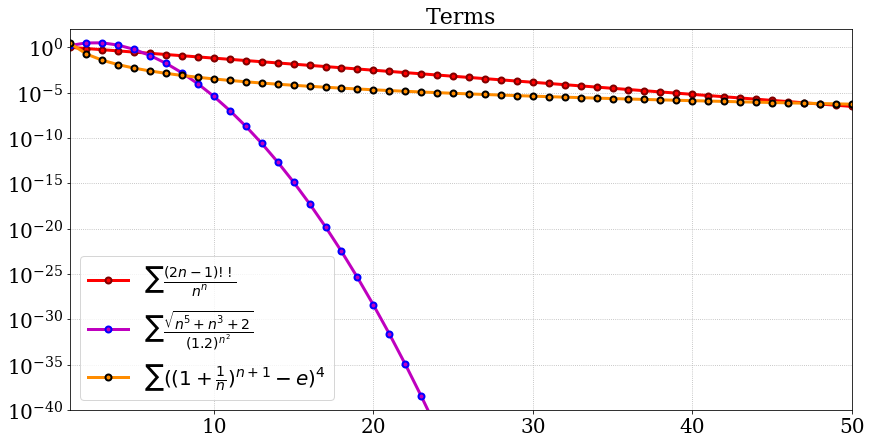

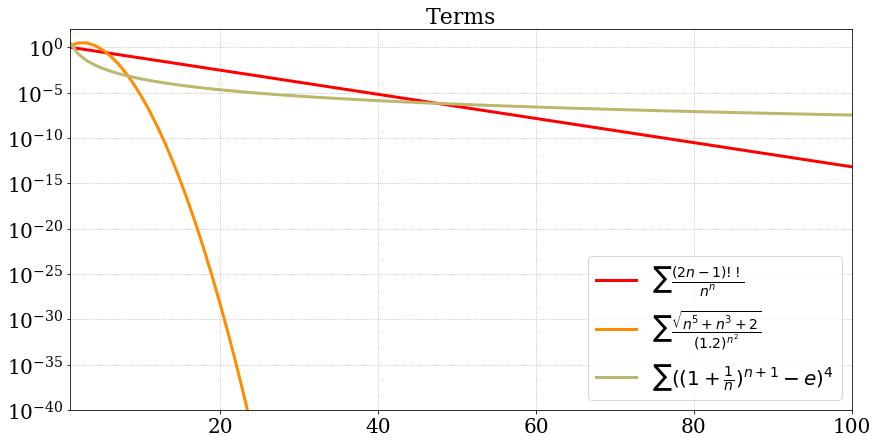

In [185]:
def a_n(x):
    fac1 = np.cumsum((np.log(2*x)+np.log(2*x-1)))
    fac2 = np.cumsum(np.log(x))
    return np.exp(fac1 - fac2 - x*np.log(2*x))
        
def b_n(x):
    return np.exp((1/2)*np.log(x**5 + x**3 + 2) - (x**2)*np.log(1.2))

def c_n(x):
    return np.exp(4*np.log(((1+1/x)**(x+1) - np.exp(1))))

series_list = [
    Series(r'$\sum{\frac{(2n-1)!!}{n^n}}$', a_n),
    Series(r'$\sum {\frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}}$', b_n),
    Series(r'$\sum {((1+\frac {1}{n})^{n+1} - e)^4}$', c_n)
]

series_list[0].estimate_sum(1, 100)
series_list[1].estimate_sum(1, 100)
series_list[2].estimate_sum(1, 100)
plot(series_list, 1, 20, 'Terms',  semilogy=True, y_lims=(-40, 2))
plot(series_list, 1, 50, 'Terms',  semilogy=True, y_lims=(-40, 2))
plot(series_list, 1, 100, 'Terms',  semilogy=True, y_lims=(-40, 2))

Do these graphs agree with the analytical solution from the previous point?

Yes, they do, as one can see, b_n terms tend to 0 very fast and it had superlinear convergence rate. Sequence a_n converges slower, but faster, that c_n, it's convergence rate is linear, on the picture it's seen that line is straight, which means it's linear. Sequence c_n converges slower than each other, since it has sulinear convergency rate.

**(2 points) 1.4.** Calculate approximately the sums of the series with the highest accuracy $\texttt{np.float64}$ would allow you to achieve (relative error should be $\sim 10^{-16}$). 
Try to find the smallest possible partial sums (i. e., the smallest possible $N_a$, $N_b$, $N_c$) appropriate for this goal.

**TIME LIMIT:** 1s.

It's necessary to find first number N, that $ S = \sum\limits_{n=1}^\infty$ $ S - S_n <= 10^{-16}$, then we had to find such N, that $S_n$ stopped increasing by more than $10^{-16}$. So I found it using method similiar to binary search by myself.

In [186]:
%%time
N_a = 208
N_b = 15
N_c = 94863
sum_a = series_list[0].estimate_sum(1, N_a)
sum_b = series_list[1].estimate_sum(1, N_b)
sum_c = series_list[2].estimate_sum(1, N_c)

Wall time: 5.95 ms


In [187]:
print("Sizes of partial sums: N_a = {}, N_b = {}, N_c = {}".format(N_a, N_b, N_c))

Sizes of partial sums: N_a = 208, N_b = 15, N_c = 94863


In [188]:
print("Sum estimations: S_a = {}, S_b = {}, S_c = {}".format(sum_a, sum_b, sum_c))

Sum estimations: S_a = 3.8627303358663845, S_b = 10.516939669523996, S_c = 2.9469899570776175


**(2 points) 1.5.** Plot the partial sums of the given series on the same picture. Consider three cases $n_{\max} = 10, 20, 40$.

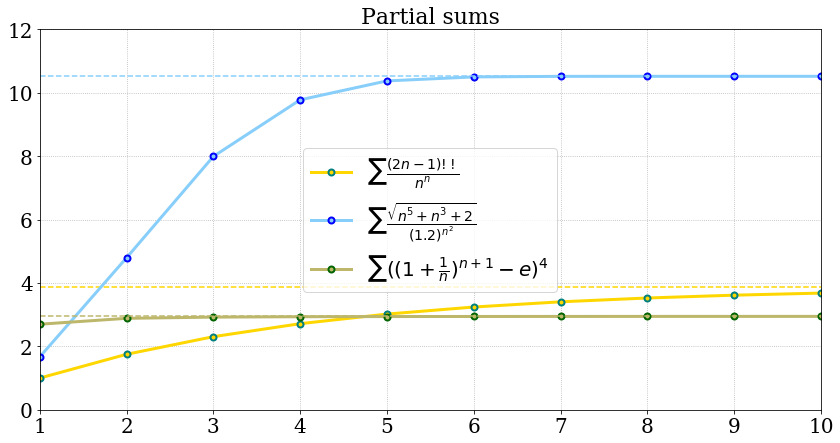

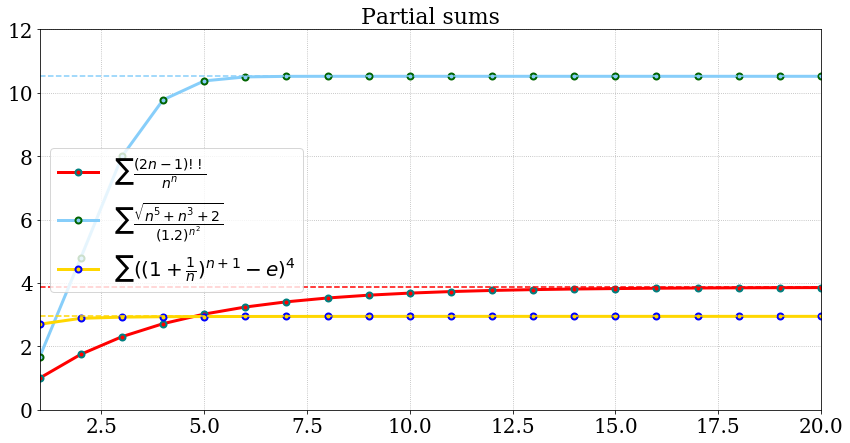

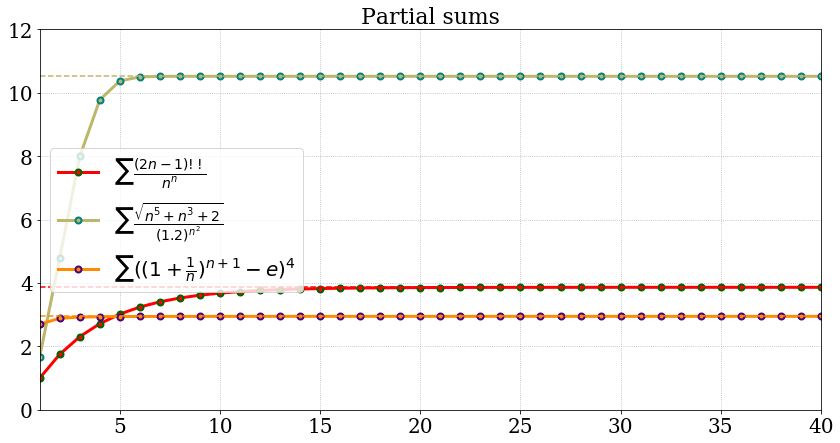

In [189]:
plot(series_list, 1, 10, 'Partial sums', y_lims=(0, 12))
plot(series_list, 1, 20, 'Partial sums', y_lims=(0, 12))
plot(series_list, 1, 40, 'Partial sums', y_lims=(0, 12))

Looking at these pictures only, can you make any justified conclusions about the rate of convergence of the series?

Actually, not really, as we can't small difference between latest terms with eye. You can only say that b_n converges rather fast to it's limit (what matches with the definition of superlinear convergence rate), we see significant increase in the beginning. A_n coverges slower, but also fast and c_n is the slowest. It may seem that c_n converges faster than each other as its partial sums does not really change after 10 terms, however, as I say, we can't see small differences on the graph. As I calculated before, rate of convergence coincides with N after which partial sums stop increasing bigger than by $10^{16}$.

To sump up, if I didn't know previous results I wouldn't be able to make truth conclusions about convergence rate.

**(2 points) 1.6.** Plot the remainders of the given series on the same picture in the logarithmic scale. Consider three cases $n_{\max} = 25, 50, 100$.

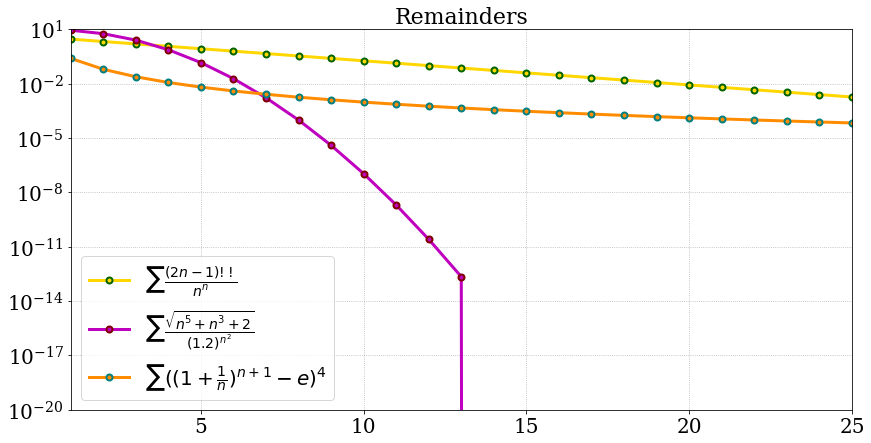

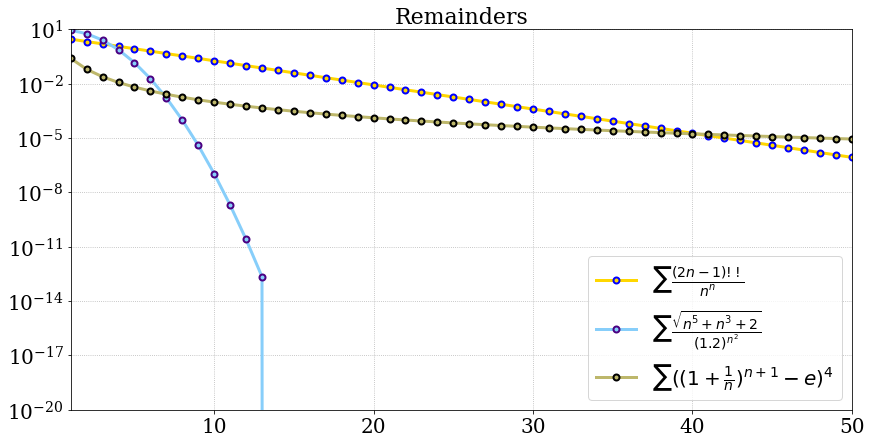

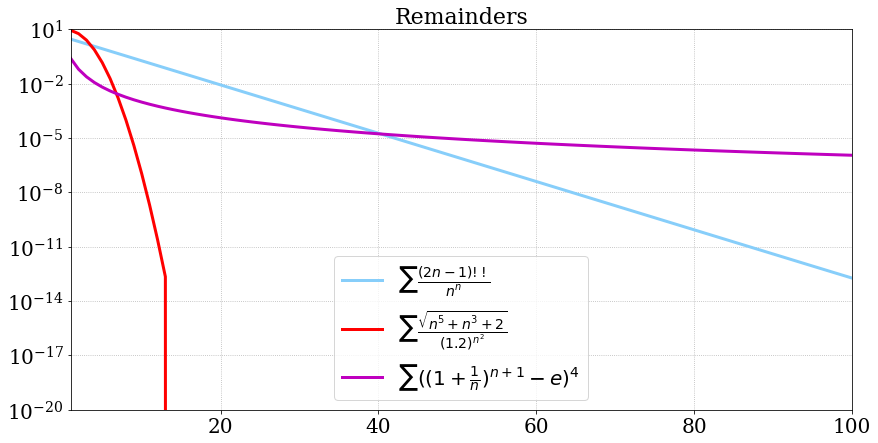

In [190]:
plot(series_list, 1, 25, 'Remainders',  semilogy=True, y_lims=(-20, 1))
plot(series_list, 1, 50, 'Remainders',  semilogy=True, y_lims=(-20, 1))
plot(series_list, 1, 100, 'Remainders',  semilogy=True, y_lims=(-20, 1))

Do the rate of convergence of the remainders coincides with that of terms $a_n$, $b_n$, $c_n$?

Yes, it does.

## 2. High precision calculation of $\pi$

Since [Pi](https://en.wikipedia.org/wiki/Pi) is irrational, it can be represented as a nonrepeating decimal fraction. The latest [record](http://www.numberworld.org/digits/Pi/) is more than 31 trillion of calculated digits. We can hardly compete with that, but to achive about $10^5$ true digits of $\pi$ is a relatively easy task. We'll use [Ramanujan's formula](https://en.wikipedia.org/wiki/Ramanujan%E2%80%93Sato_series)
$$
\frac 1\pi = \frac{2\sqrt 2}{9801} \sum\limits_{k=0}^\infty \frac{(4k)! (1103 + 26390k)}{(k!)^4 396^{4k}}
$$

Given $n\in\mathbb N$, we can calculate the partial sum 
$$
S_n =\sum\limits_{k=0}^n \frac{(4k)! (1103 + 26390k)}{(k!)^4 396^{4k}}.
$$

Now $\pi\approx \frac {9801}{2\sqrt 2 S_n}$.

**(4 points) 2.1.** Using the [$\texttt{Decimal}$](https://docs.python.org/3.7/library/decimal.html#module-decimal) module, calculate $\frac 1{S_n}$.

**TIME LIMIT:** 3s if $n \leqslant 1000$.

In [191]:
from decimal import *

def calculate_pi(n):
    '''
        n, int : number of terms to sum up
        returns: Decimal object, approximate value of pi
    '''
    getcontext().prec = n*9
    root = Decimal('2').sqrt()
    COEF = Decimal('9801')/Decimal('2')
    COEF = COEF/root
    fac = [Decimal('1')]
    for i in range(2, 4*n+1):
        fac.append(Decimal(i)*fac[-1])
    
    S = Decimal('1103')
    for i in range(1, n+1):
        temp = Decimal('1103') + Decimal('26390') * Decimal(i)
        temp = temp * fac[i*4-1]
        temp = temp / (fac[i-1])**4
        temp = temp / Decimal('396')**(Decimal('4') * Decimal(i))
        S = S + temp
    S = Decimal('1')/S
    COEF = COEF * S
    return COEF
    
calculate_pi(100)

Decimal('3.14159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847564823378678316527120190914564856692346034861045432664821339360726024914127372458700660631558817488152092096282925409171536436789259036001133053054882046652138414695194151160943305727036575959195309218611738193261179310511854807446237996274956735188575272489122793818301194912983367336244065664308602139494639522473719070217986094370277053921717629317675238467481846766940513200056812714526356082778577134275778960917363717872146844090122495343014654958537105079227968925892354201995611212902196086403441815981362977477130996051870721134999999837297804995105973173281609631859502446494861239670454651923632232820014852108006147821950033155755471848976991894903185426810142712')

In [192]:
%%timeit
big_pi = calculate_pi(1000)

3.54 s ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


$Remark$ time limit is slightly exceeded, but it's ok since lecturer told us that limit is constant*3s. Moreover, it can be less that 3s if I decrease precision, but I wanted to get more digits for next tasks.

A verification file containing a billion digits of $\pi$ can be downloaded from [here](https://archive.org/details/Math_Constants).

In [193]:
from os.path import commonprefix

def read_in_chunks(file_object, chunk_size=1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

def check_number(test_number, file_name):    
    i = 0
    chunk_size = 1000
    with open(file_name) as f:
        for piece in read_in_chunks(f, chunk_size):
            common = commonprefix([piece, test_number[i:i + chunk_size]])
            common_len = len(common)
            i += common_len
            if common_len != chunk_size:
                break
    return i - 2

PATH_TO_DIGITS = "pi.txt"

def test_big_pi(calc_func, n_max=2000, size=10,
                path_to_digits=PATH_TO_DIGITS):
    np.random.seed(np.datetime64('now').astype(np.int64))
    random_ns = np.random.randint(1, n_max + 1, size=size)
    for n in random_ns:
        big_pi = calc_func(int(n))
        true_digits = check_number(str(big_pi), path_to_digits)
        print("number of terms = {}, true digits = {}, ratio = {}".format(n, true_digits, true_digits / n))

In [194]:
%%time
test_big_pi(calculate_pi)

number of terms = 1701, true digits = 13586, ratio = 7.987066431510876
number of terms = 1777, true digits = 14193, ratio = 7.987056837366348
number of terms = 805, true digits = 6434, ratio = 7.992546583850932
number of terms = 382, true digits = 3056, ratio = 8.0
number of terms = 1974, true digits = 15765, ratio = 7.986322188449848
number of terms = 1933, true digits = 15437, ratio = 7.986032074495602
number of terms = 1717, true digits = 13714, ratio = 7.987186953989516
number of terms = 838, true digits = 6697, ratio = 7.991646778042959
number of terms = 1677, true digits = 13394, ratio = 7.986881335718545
number of terms = 1490, true digits = 11901, ratio = 7.987248322147651
Wall time: 2min 6s


**(2 points) 2.2.** Let $t(n)$ and $d(n)$ be the execution time of your $\texttt{calculate}$_$\texttt{pi}$ function and the number of true digits returned by it respectively. Plot their graphs for $n=10, 20, \ldots, 1000$. What can you say about the asymptotics of $t(n)$ and $d(n)$?

Well, looking at the graph with the number of true digits I can say that line is quite straight, that means that $d(n)$ is a linear function, probably $O(n)$ then. And another graph with time looks like quadratic function that was multipled by some constant (I plotted quadratic functions on drafts to compare them), i.e. $c\cdot2^{n} = t(n)$, hence $t(n) = O(n^{2})$

In [195]:
import time

def get_pi_times_and_digits(n_range, func,  
                            path_to_digits=PATH_TO_DIGITS):
    times = []
    digits = []
    PATH_TO_DIGITS = "pi.txt"
    
    for n in n_range:
        start = time.time()
        big_pi = func(int(n))
        end = time.time()
        true_digits = check_number(str(big_pi), path_to_digits)
        digits.append(true_digits)
        times.append((end - start) * 1000)
    
    return times, digits

def plot_pi_list(n_range, pi_list, ylabel):
    plt.figure(figsize=(14,7))
    plt.plot(n_range, pi_list, c='r', lw=2)
    plt.xlim(n_range[0], n_range[-1])
    plt.ylim(0)
    plt.xlabel("n")
    plt.ylabel(ylabel)
    plt.grid(ls=':')

In [196]:
%%time
n_slow = np.arange(10, 1001, 10)
pi_times, pi_digits = get_pi_times_and_digits(n_slow, calculate_pi)

Wall time: 1min 31s


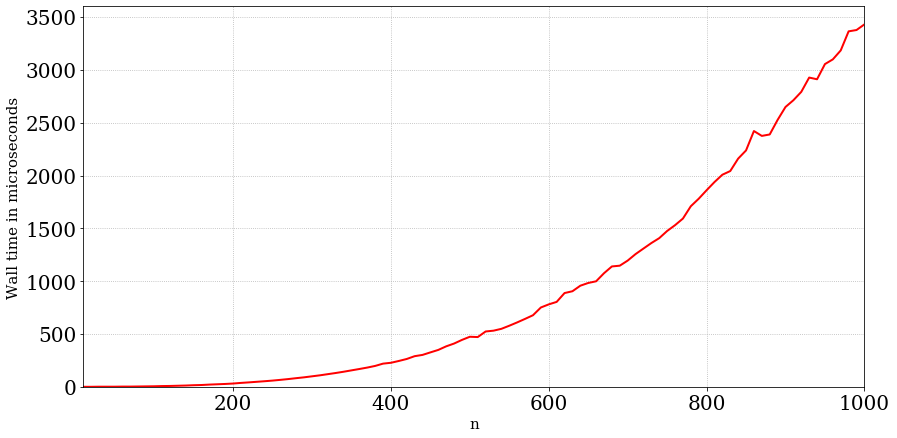

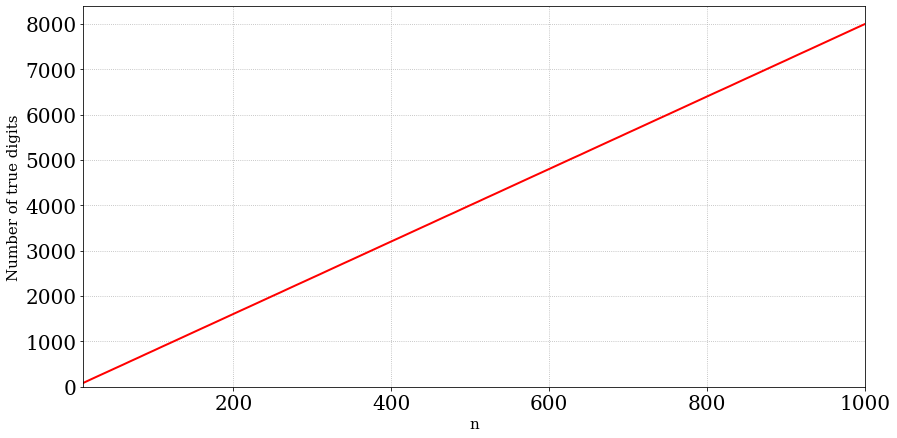

In [197]:
plot_pi_list(n_slow, pi_times, "Wall time in microseconds")
plot_pi_list(n_slow, pi_digits, "Number of true digits")

**(4 points) 2.3.** Using the Binary splitting technique ([this](http://www.numberworld.org/y-cruncher/internals/binary-splitting.html) and [this](http://www.numberworld.org/y-cruncher/internals/binary-splitting-library.html#pi_ramanujan)), construct a faster algorithm for calculating digits of $\pi$.

**TIME LIMIT:** 10s for $n\leqslant 10^4$.

In [198]:
def R(a, b):
    if b == a + Decimal('1'):
        m1 = Decimal('2')*Decimal(b) - Decimal('1')
        m2 = Decimal('4')*Decimal(b) - Decimal('3')
        m3 = Decimal('4')*Decimal(b) - Decimal('1')
        return m1 * m2 * m3
    else:
        m = (b - a) // Decimal('2')
        m = b - m
        return R(a, m)* R(m, b)

def Q(a, b):
    if b == a + Decimal('1'):
        q = Decimal('3073907232') * Decimal(b)**3
        return q
    else:
        m = (b - a) // Decimal('2')
        m = b - m
        return Q(a, m) * Q(m, b)
    
def P(a, b):
    if b == a + Decimal('1'):
        m1 = Decimal('26390')*Decimal(b) + Decimal('1103')
        m2 = Decimal('2')*Decimal(b) - Decimal('1')
        m3 = Decimal('4')*Decimal(b) - Decimal('3')
        m4 = Decimal('4')*Decimal(b) - Decimal('1')
        return m1 * m2 * m3 * m4
    else:
        m = (b - a) // Decimal('2')
        m = b - m
        return P(a, m) * Q(m, b) + P(m, b) * R(a, m)
        
        
def calculate_pi_fast(n):
    getcontext().prec = n*9
    n = Decimal(n)
    COEF = Decimal('9801') * Q(Decimal('0'), n)
    root = Decimal('1') / Decimal('8').sqrt()
    denominator = P(Decimal('0'), n) + Decimal('1103') * Q(Decimal('0'), n)
    return root * COEF / denominator

In [199]:
%%timeit
big_pi_fast = calculate_pi_fast(10 ** 4)

2.08 s ± 40.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [200]:
%%time
test_big_pi(calculate_pi_fast, n_max=1000)

number of terms = 854, true digits = 6824, ratio = 7.990632318501171
number of terms = 59, true digits = 478, ratio = 8.101694915254237
number of terms = 725, true digits = 5795, ratio = 7.993103448275862
number of terms = 976, true digits = 7798, ratio = 7.989754098360656
number of terms = 480, true digits = 3838, ratio = 7.995833333333334
number of terms = 290, true digits = 2322, ratio = 8.006896551724138
number of terms = 261, true digits = 2091, ratio = 8.011494252873563
number of terms = 144, true digits = 1156, ratio = 8.027777777777779
number of terms = 665, true digits = 5316, ratio = 7.993984962406015
number of terms = 114, true digits = 917, ratio = 8.043859649122806
Wall time: 439 ms


**(3 points) 2.4.** Let $t_f(N)$ and $d_f(N)$ be the execution time of your $\texttt{calculate}$_$\texttt{pi}$_$\texttt{fast}$ function. Plot the graph of $t_f(N)$ and $d_f(N)$ for $N=10, 20, \ldots, 2000$. Also plot both graphs of $t(N)$ and $t_f(N)$ on the same picture. What can you say about the asymptotics of $t_f(N)$?

In [201]:
%%time
n_fast = np.arange(10, 2001, 10)
pi_times_fast, pi_digits_fast = get_pi_times_and_digits(n_fast, func=calculate_pi_fast)

Wall time: 26.9 s


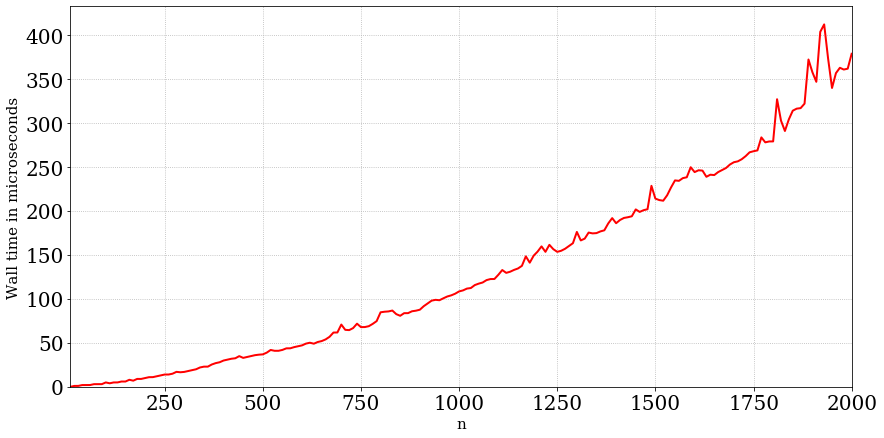

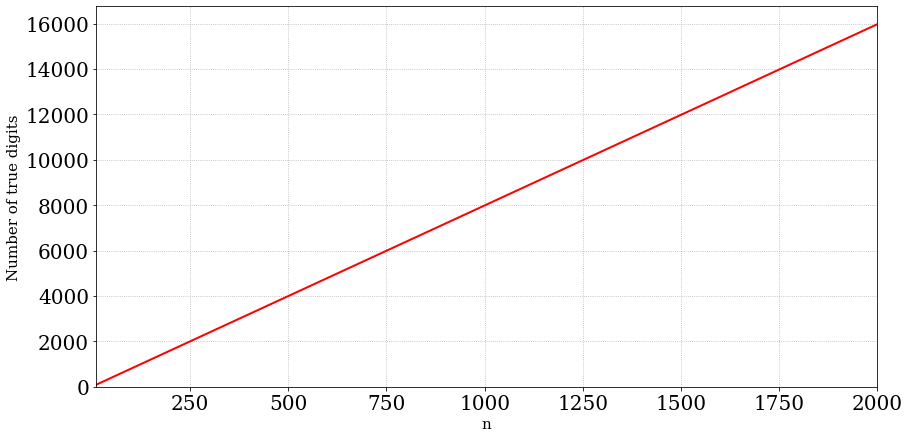

In [202]:
plot_pi_list(n_fast, pi_times_fast, "Wall time in microseconds")
plot_pi_list(n_fast, pi_digits_fast, "Number of true digits")

In [203]:
def plot_pi_times_both(range_list, times_list, labels):
    plt.figure(figsize=(14,7))
    colors = ['r', 'b', 'm', 'c']
    N_max = 0
    for i, times in enumerate(times_list):
        N = range_list[i][-1]
        N_max = max(N_max, N)
        plt.plot(range_list[i], times, c=colors[i], lw=2, label=labels[i])
    plt.xlim(1, N_max)
    plt.ylim(0)
    plt.xlabel("n")
    plt.ylabel("time, ms")
    plt.grid()
    plt.legend();

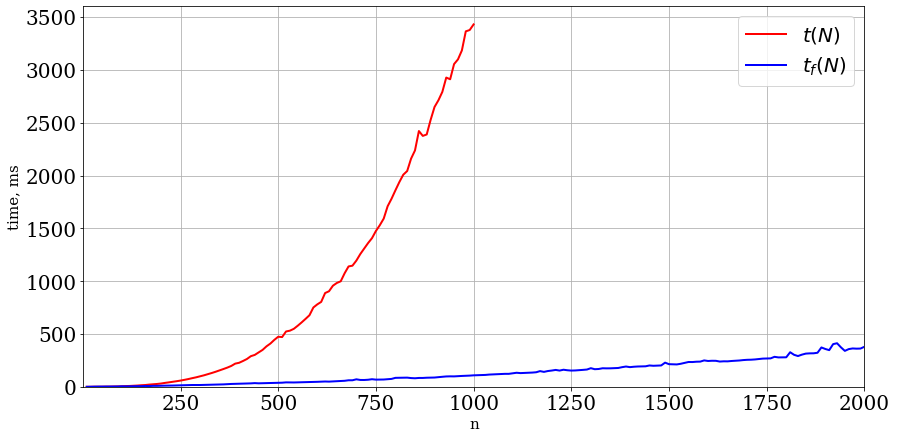

In [204]:
range_list = [n_slow, n_fast]
pi_times_both = [pi_times, pi_times_fast]
labels = ['$t(N)$', '$t_f(N)$']
plot_pi_times_both(range_list, pi_times_both, labels)

What can you say about the asymptotics of $t_f(N)$?
Well, it looks like $constant\cdot n$, i.e. $O(n)$, because we can compare it's values on the n=500,1000,1500,2000 and see that $t_f(c\cdot n)$ = $c\cdot t_f(n)$

**(1 point) 2.5**. Now it's time to calculate $200$ thousands digits of $\pi$:

**TIME LIMIT.** 3m.

In [206]:
%%time

def get_true_digits(n_range, func,  
                            path_to_digits=PATH_TO_DIGITS):
    digits = []
    PATH_TO_DIGITS = "pi.txt"
    for n in n_range:
        big_pi = func(int(n))
        true_digits = check_number(str(big_pi), path_to_digits)
        digits.append(true_digits)
    return digits
        
n = [200000 // 7]
true_digits = get_true_digits(n, func=calculate_pi_fast)
print("{} true digits of pi were calculated!".format(true_digits[-1]))

228077 true digits of pi were calculated!
Wall time: 6.54 s
